# Kaggle Competition: House Price Prediction

**Contents**
 + Part 1. EDA
 + Part 2. Feature Engineering
 + Part 3. Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv('train.csv',header=0)
test = pd.read_csv('test.csv',header=0)

# Part 1. Exploratory Data Analysis

Let's preview data first. This house price data consists of 81 columns and 1460 rows. `SalePrice` variabls is our target variable and now in **EDA part**, we are going to get insight from each variables and discover how to deal with those values well.

In [3]:
# preview train data
print(train.head())
print('\n')
print(train.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

## (1) Deal with missing data(variables)
By previewing our data, we can easily see that there are lots of missing values in house price data. Therefore, we'll start with removing variables with too many missing data and find out how to impute those variables efficiently.

First, check the number of missing values in each variables of house price data. 
 + There are 19 variables which have missing data, and we are going to delete variables with too many missing variables. I'll remove variables with missing percentage more than 40%.
 + Therefore, remove `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu` variables.
 + It's quite unsure wheter to delete `FireplaceQu` variable or not. We're going to decide how to deal with this variable later.

In [4]:
def get_missing(df):
    missing = train.isnull().sum().sort_values(ascending=False).reset_index().rename(columns={'index':'variable',0:'count'})
    missing = missing[missing['count']>0]
    missing['missing_ratio'] = np.round(missing['count']/len(train),4)
    return missing
get_missing(train)

,variable,count,missing_ratio
0,PoolQC,1453,0.9952
1,MiscFeature,1406,0.9630
2,Alley,1369,0.9377
3,Fence,1179,0.8075
4,FireplaceQu,690,0.4726
5,LotFrontage,259,0.1774
6,GarageCond,81,0.0555
7,GarageType,81,0.0555
8,GarageYrBlt,81,0.0555
9,GarageFinish,81,0.0555


In [5]:
# drop variable with too many missing values(>50%)
train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
print(train.shape)

(1460, 76)


### Missing data Imputation
We will try several imputation method to impute missing data. Since missing percentage of each variable is different, I'm going to apply different imputation method to each variable. For variables with very low percentage of missing data(under 10%), I'll apply mean imputation and for other variable, I'll apply regression/hotdeck/imputation cell method. <br>

**Imputation method list**
 + mean imputation
 + hotdeck imputation

In [6]:
# missing data list & percentage of missing
missing = get_missing(train)

#### 1) missing percentage under 10% 
Caution) For variable with missing percentage under 10%, there are several object columns so it's hard to apply mean imputation. However, if you take a look at data description, for object columns NA means 'There is no garage/basement'. So we are not going to impute object type variables. 
 + `MasVnrArea`: mean imputation
 + `GarageYrBlt`: ????
 + `Electrical`, `MasVnrType`: there's only one/eight missing data in this variable, so just delete it!

In [7]:
missing_under10 = missing[missing['missing_ratio']<0.1]
missing_under10

,variable,count,missing_ratio
1,GarageFinish,81,0.0555
2,GarageType,81,0.0555
3,GarageCond,81,0.0555
4,GarageQual,81,0.0555
5,GarageYrBlt,81,0.0555
6,BsmtExposure,38,0.0260
7,BsmtFinType2,38,0.0260
8,BsmtFinType1,37,0.0253
9,BsmtCond,37,0.0253
10,BsmtQual,37,0.0253


In [8]:
# check dtypes of variables
train[missing_under10['variable'].unique()].dtypes

GarageFinish     object
GarageType       object
GarageCond       object
GarageQual       object
GarageYrBlt     float64
BsmtExposure     object
BsmtFinType2     object
BsmtFinType1     object
BsmtCond         object
BsmtQual         object
MasVnrType       object
MasVnrArea      float64
Electrical       object
dtype: object

`GarageYrBlt` is float type varialbe and it denotes year when garage was built. Therefore it's not adequate to mean impute missing values in `GarageYrBlt` variable, since year cannot be calculated with mean. Then how should we deal with those missing values? <br>

Let's check missing values in `GarageYrBlt` and their relationship with other Garage related variables. It's interesting to check that if `GarageYrBlt` has Nan value, other Garage related variables also have Nan value. Same applis to `Bsmt` related variables. 
<br>
We can conclude that **it's more reasonable to delete those missing values in Garage & Bsmt related variables**, for below reasons.
 + missing percentage in garage variables are only 5% and 2% each.
 + it's impossible to impute **year** without any information.

In [9]:
train[train['BsmtExposure'].isna()==True][missing_under10['variable'].unique()].head()

,GarageFinish,GarageType,GarageCond,GarageQual,GarageYrBlt,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrType,MasVnrArea,Electrical
17,Unf,CarPort,TA,TA,1967.0,NaN,NaN,NaN,NaN,NaN,None,0.0,SBrkr
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,FuseP
90,Unf,Detchd,TA,TA,1950.0,NaN,NaN,NaN,NaN,NaN,None,0.0,FuseA
102,Unf,Attchd,TA,TA,1979.0,NaN,NaN,NaN,NaN,NaN,None,0.0,SBrkr
156,Unf,Detchd,TA,TA,1950.0,NaN,NaN,NaN,NaN,NaN,None,0.0,FuseF


In [10]:
train[train['GarageYrBlt'].isna()==True][missing_under10['variable'].unique()].head()

,GarageFinish,GarageType,GarageCond,GarageQual,GarageYrBlt,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrType,MasVnrArea,Electrical
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,FuseP
48,NaN,NaN,NaN,NaN,NaN,No,Unf,Unf,TA,TA,None,0.0,SBrkr
78,NaN,NaN,NaN,NaN,NaN,No,Unf,Unf,TA,TA,None,0.0,SBrkr
88,NaN,NaN,NaN,NaN,NaN,No,Unf,Unf,Fa,TA,None,0.0,SBrkr
89,NaN,NaN,NaN,NaN,NaN,No,Unf,GLQ,TA,Gd,None,0.0,SBrkr


**Mean imputation & deletion of data**

First, delete missing data in `GarageYrBlt` variable. Then according to result below, missing values in `Garage` related variables are all deleted. 

In [11]:
# deletion of missing data in garage data
train = train.dropna(subset=['GarageYrBlt','BsmtExposure','BsmtFinType2'])

In [12]:
get_missing(train)

,variable,count,missing_ratio
0,LotFrontage,246,0.1826
1,MasVnrType,8,0.0059
2,MasVnrArea,8,0.0059
3,Electrical,1,0.0007


Next, conduct mean imputation to `MasVnrArea` variable and compare before and after imputation data.
I made `train2` data, which is mean imputed data of train data just to compare results. 
<br>
 + Roughly, distribution of `MasVnrArea` before and after imputation shows no difference! To be more specific, mean of before and after mean imputation is same(since this is mean imputation). <br>
 + However, variance of mean imputed data was little bit smaller than that of original train data. This is because if we mean impute missing data, density of mean value increases and therefore leads to underestiamtion of variance. But, we don't need to worry in this case. Distribution plot of before/after imputation are almost the same and difference in variance is about 20, which is negligable.

In [13]:
# mean imputation
train2 = train.copy()
train2['MasVnrArea'].fillna(train2['MasVnrArea'].mean(),inplace=True)

In [53]:
def compare_imputation(original,imputed, variable):
    plt.subplot(1,2,1)
    sns.distplot(original[variable])
    plt.title('Distribution before imputation')
    plt.subplot(1,2,2)
    sns.distplot(imputed[variable],color='red')
    plt.tight_layout()
    plt.title('Distribution after imputation')
    plt.show()
    
    print('##### Before mean imputation #####')
    print('mean:' ,original[variable].mean())
    print('variance: ',original[variable].var())
    print('\n')
    print('##### After mean imputation #####')
    print('mean: ',imputed[variable].mean())
    print('variance: ',imputed[variable].var())

compare_imputation(train,train2)

In [16]:
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(),inplace=True)

In [21]:
# drop missing data in Electrical & MasVnrType
train = train.dropna(subset=['Electrical'])
train = train.dropna(subset=['MasVnrType'])

In [22]:
get_missing(train)

,variable,count,missing_ratio
0,LotFrontage,244,0.1824


#### 2) missing percentage over 10% 
: `LotFrontage`

**1st method: Mean imputation** <br>
If we impute `LonFrontage` with mean imputation method, the result is quite different from above `MasVnrArea` case. First, distribution of before and after imputation of data is definetly different. After imputation distribution is much denser around mean value. <br>
Therefore, **underestimation of variance occurs when we conduct mean imputation.**

In [36]:
train_compare1 = train.copy()
train_compare1['LotFrontage'].fillna(train_compare1['LotFrontage'].mean(),inplace=True)

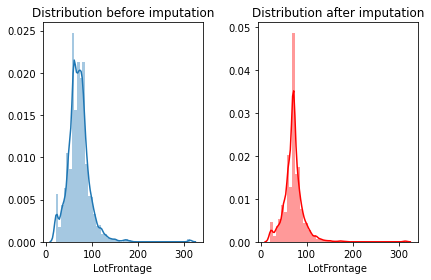

##### Before mean imputation #####
mean: 70.75959780621572
variance:  600.6841484199757


##### After mean imputation #####
mean:  70.75959780621582
variance:  491.06041452732416


In [54]:
compare_imputation(train,train_compare1,'LotFrontage')

**2nd method: Hotdeck imputation** <br>
Hotdeck imputation is the imputation method which imputed missing data by random sampling complete data. In python, we can conduct hotdeck imputation using `ffill` or `bfill`. In this case, I used `ffil` method. <br>
Following result is quite interesting. Unlike mean imputation method, there is very small bias in variance and mean bias is also small. Also, distribution of before and after imputation is very similar. <br>

Therefore, it's better to apply **Hotdeck imputation** to `LotFrontage` variable.

In [50]:
train_compare2 = train.copy()
train_compare2['LotFrontage'].fillna(method='ffill',inplace=True)

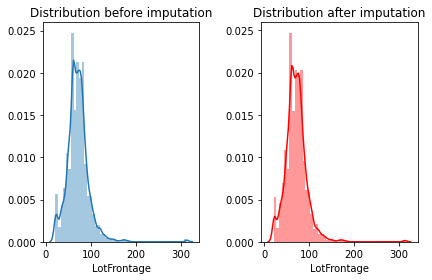

##### Before mean imputation #####
mean: 70.75959780621572
variance:  600.6841484199757


##### After mean imputation #####
mean:  70.70029895366218
variance:  578.8263424685206


In [55]:
compare_imputation(train,train_compare2,'LotFrontage')

In [82]:
# apply hotdeck imputation to train data
train['LotFrontage'].fillna(method='ffill',inplace=True)
get_missing(train)

,variable,count,missing_ratio


## (2) Explore Target variable: `SalePrice`
Distribution of `SalePrice` is skewed. Therefore, we may need to apply `np.log1p` to conduct linear regression.

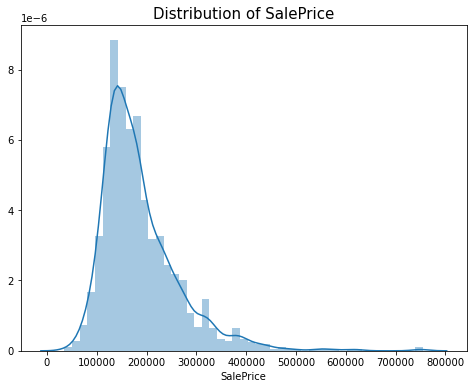

In [89]:
plt.figure(figsize=(8,6))
sns.distplot(train['SalePrice'])
plt.title('Distribution of SalePrice', fontsize=15)
plt.show()

If you take a loot at QQ-plot of `SalePrice`, you can easily see that values of `SalePrice` deviates from straight red line. Theoretically, if QQ-plot deviates from straight line, we say that this variable does not follow normal distribution.
<br>
So `SalePrice` does not follow normal distribution.

((array([-3.28061069, -3.02161974, -2.87748242, ...,  2.87748242,
          3.02161974,  3.28061069]),
  array([ 35311,  40000,  55993, ..., 625000, 745000, 755000], dtype=int64)),
 (73294.8811950251, 186761.78251121077, 0.927144186972872))

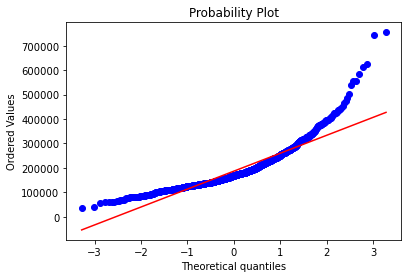

In [97]:
import scipy.stats as stats
import pylab
stats.probplot(train['SalePrice'],dist='norm',plot=pylab)

## (3) Explanatory variables(설명변수)

### 1) Check correlation heatmap between variables
Draw heatmap of correlation between explanatory variables. These are lists of variables with high correlation(more than 0.7).
 + `1stFlrSF`, `TotalBsmtSF`: 0.89
 + `GarageYrBlt`, `YearBlt`: 0.83
 + `TotRmsAbvGrd`, `GrLivArea`: 0.82
 + `GarageArea`, `GarageCars`: 0.83

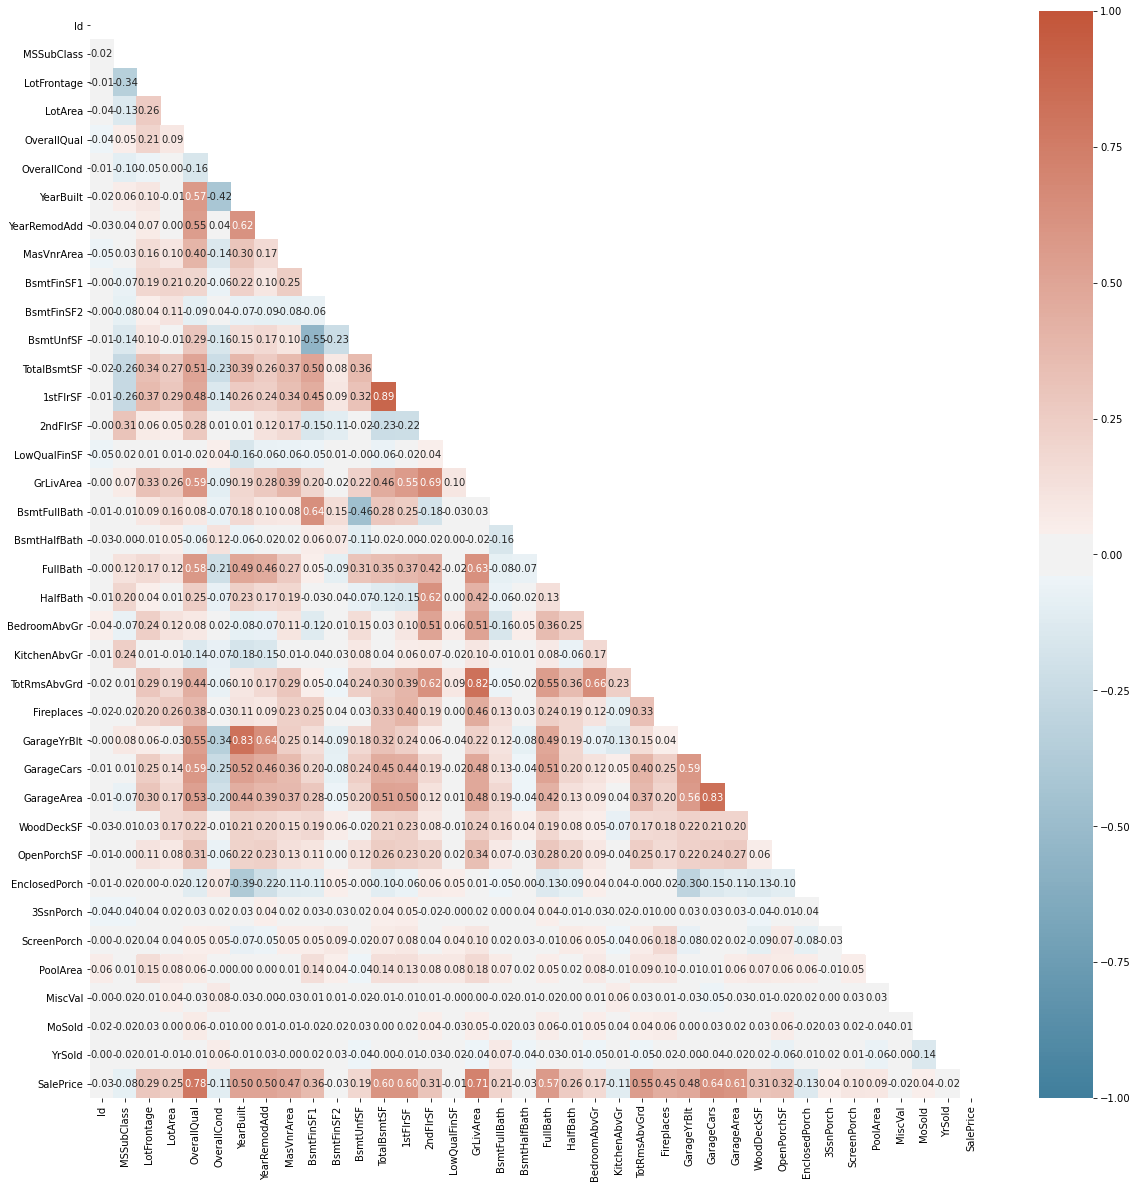

In [91]:
corr_mat = train.corr()
mask = np.triu(np.ones_like(corr_mat,dtype=np.bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.2f')

### 2) Top 6 variables highly correlated with Target `SalePrice`
We are going to get Top 6 variable that are highly correlated with `SalePrice` and analyze those. Below is the list of those variables.

In [141]:
corr_mat['SalePrice'].sort_values(ascending=False)[1:7]

OverallQual    0.783546
GrLivArea      0.711706
GarageCars     0.640154
GarageArea     0.607535
1stFlrSF       0.604714
TotalBsmtSF    0.602042
Name: SalePrice, dtype: float64

#### `OverallQual`(categorical): Overall material and finish quality
`OverallQual` variable consists of 9 categories. Larger value denotes that overall quality of house is better. To see relationship with `SalePrice`, I drew catplot using seaborn package. 
**Higher overall quality means higher sale price.**

Text(0.5, 0, 'OverallQual')

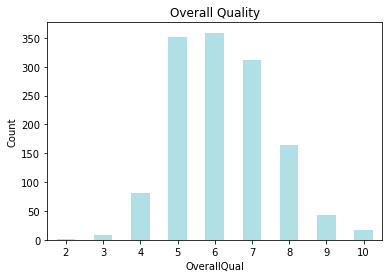

In [117]:
train['OverallQual'].value_counts().sort_index().plot.bar(color='powderblue')
plt.title('Overall Quality');plt.xticks(rotation=0);plt.ylabel('Count');plt.xlabel('OverallQual')

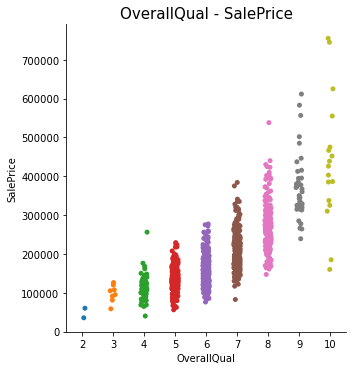

In [121]:
sns.catplot(data=train,x='OverallQual',y='SalePrice')
plt.title('OverallQual - SalePrice',fontsize=15)
plt.show()

#### `GrLivArea`(integer):  Above grade (ground) living area square feet
This jointplot shows that `GrLivArea` and `SalePrice` is positvely correated. Therefore, `GrLivArea` is one of the important variables to predict `SalePrice`.

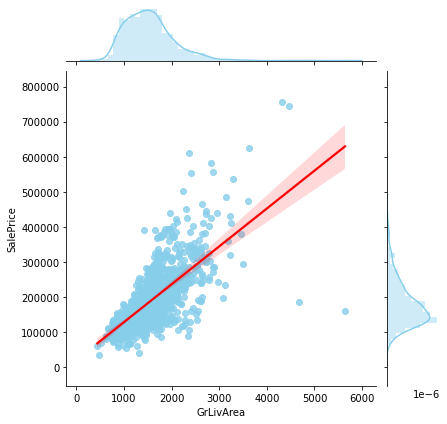

In [134]:
sns.jointplot(x="GrLivArea", y="SalePrice", data=train, kind='reg',joint_kws={'line_kws':{'color':'red'}},color='skyblue')
plt.show()

#### `GarageCars` and `GarageArea`: Size of garage in car capacity/ Size of garage in square feet
`GarageCars` means size of garage in car capacity and `GarageArea` means size of garage in square feet. Those two variables both represents size of garage so they are quite similar variables! (Maybe we can delete one of those variables since there can be multicolinearity error.) <br>
And we can check this in graphs belows. `GarageCars` is categorical variable with 4 categories(1-4) and except category 4, the larger category values are, the greater `GarageArea` is.

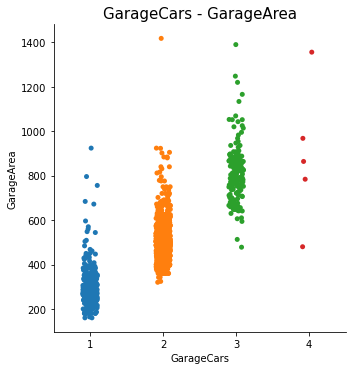

In [136]:
sns.catplot(data=train,x='GarageCars',y='GarageArea')
plt.title('GarageCars - GarageArea',fontsize=15)
plt.show()

This joinplot shows that `GarageArea` and `SalePrice` is positively correlated. Since `GarageCars` and `GarageArea` are positively correlated, so do `GarageCars` and `SalePrice`.

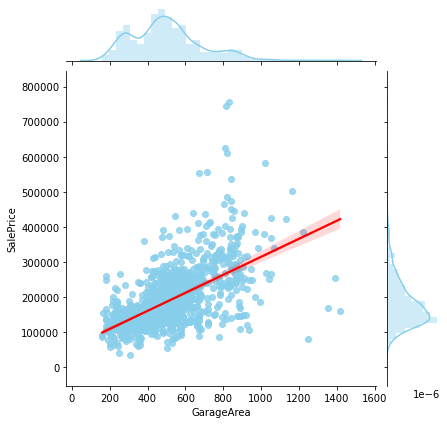

In [140]:
sns.jointplot(x="GarageArea", y="SalePrice", data=train, kind='reg',joint_kws={'line_kws':{'color':'red'}},color='skyblue')
plt.show()

#### `1stFlrSF` and `TotalBsmtSF`: First Floor square feet / Total square feet of basement area

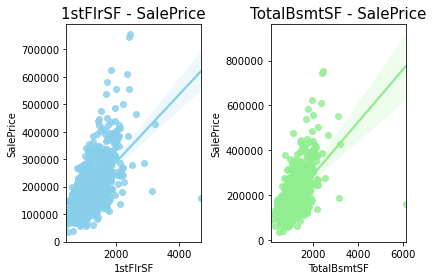

In [149]:
plt.subplot(1,2,1)
sns.regplot(x="1stFlrSF", y="SalePrice", data=train,color='skyblue')
plt.title('1stFlrSF - SalePrice',fontsize=15)
plt.subplot(1,2,2)
sns.regplot(x="TotalBsmtSF", y="SalePrice", data=train,color='lightgreen')
plt.title('TotalBsmtSF - SalePrice',fontsize=15)
plt.tight_layout()
plt.show()